In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./RNN_scripts")
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns
import pickle

import MARBLE
from MARBLE import utils, geometry, plotting, postprocessing, compare_attractors
from sklearn.decomposition import PCA

/Users/gosztola/opt/anaconda3/envs/MARBLE/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [3]:
hidden_size = 500
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [ ]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

# Visualising two network populations

In [ ]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

In [ ]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])

# Create new network by fitting Gaussian mixture to the connectivity space

In [ ]:
net3 = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [ ]:
accs2 = []
for _ in range(10):
    net3.resample_basis()
    loss, acc = dms.test_dms(net3, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [ ]:
train(net3, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

# Generate data

In [8]:
input[i].unsqueeze(0).shape

torch.Size([1, 275, 4])

In [11]:
n_traj=50
n_conds=20

stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
gain = np.linspace(1,0,n_conds)

input = torch.zeros(n_conds, decision, 2)
for i, g in enumerate(gain):
    input[i, stim1_begin:stim1_end, 0] = g
    input[i, stim2_begin:stim2_end, 0] = g

traj = []
for i in range(n_conds):
    conds = []
    for k in range(n_traj):
        #net.h0.data = torch.rand(size=net.h0.data.shape) #random ic
        _, traj_ = net(input[i].unsqueeze(0))
        traj_ = traj_.squeeze().detach().numpy()
        traj_epoch = [traj_[e:epochs[j+1]] for j, e in enumerate(epochs[:-1])]
        conds.append(traj_epoch)
        
    traj.append(conds)

# Plot phase portraits of the original system for various parameters

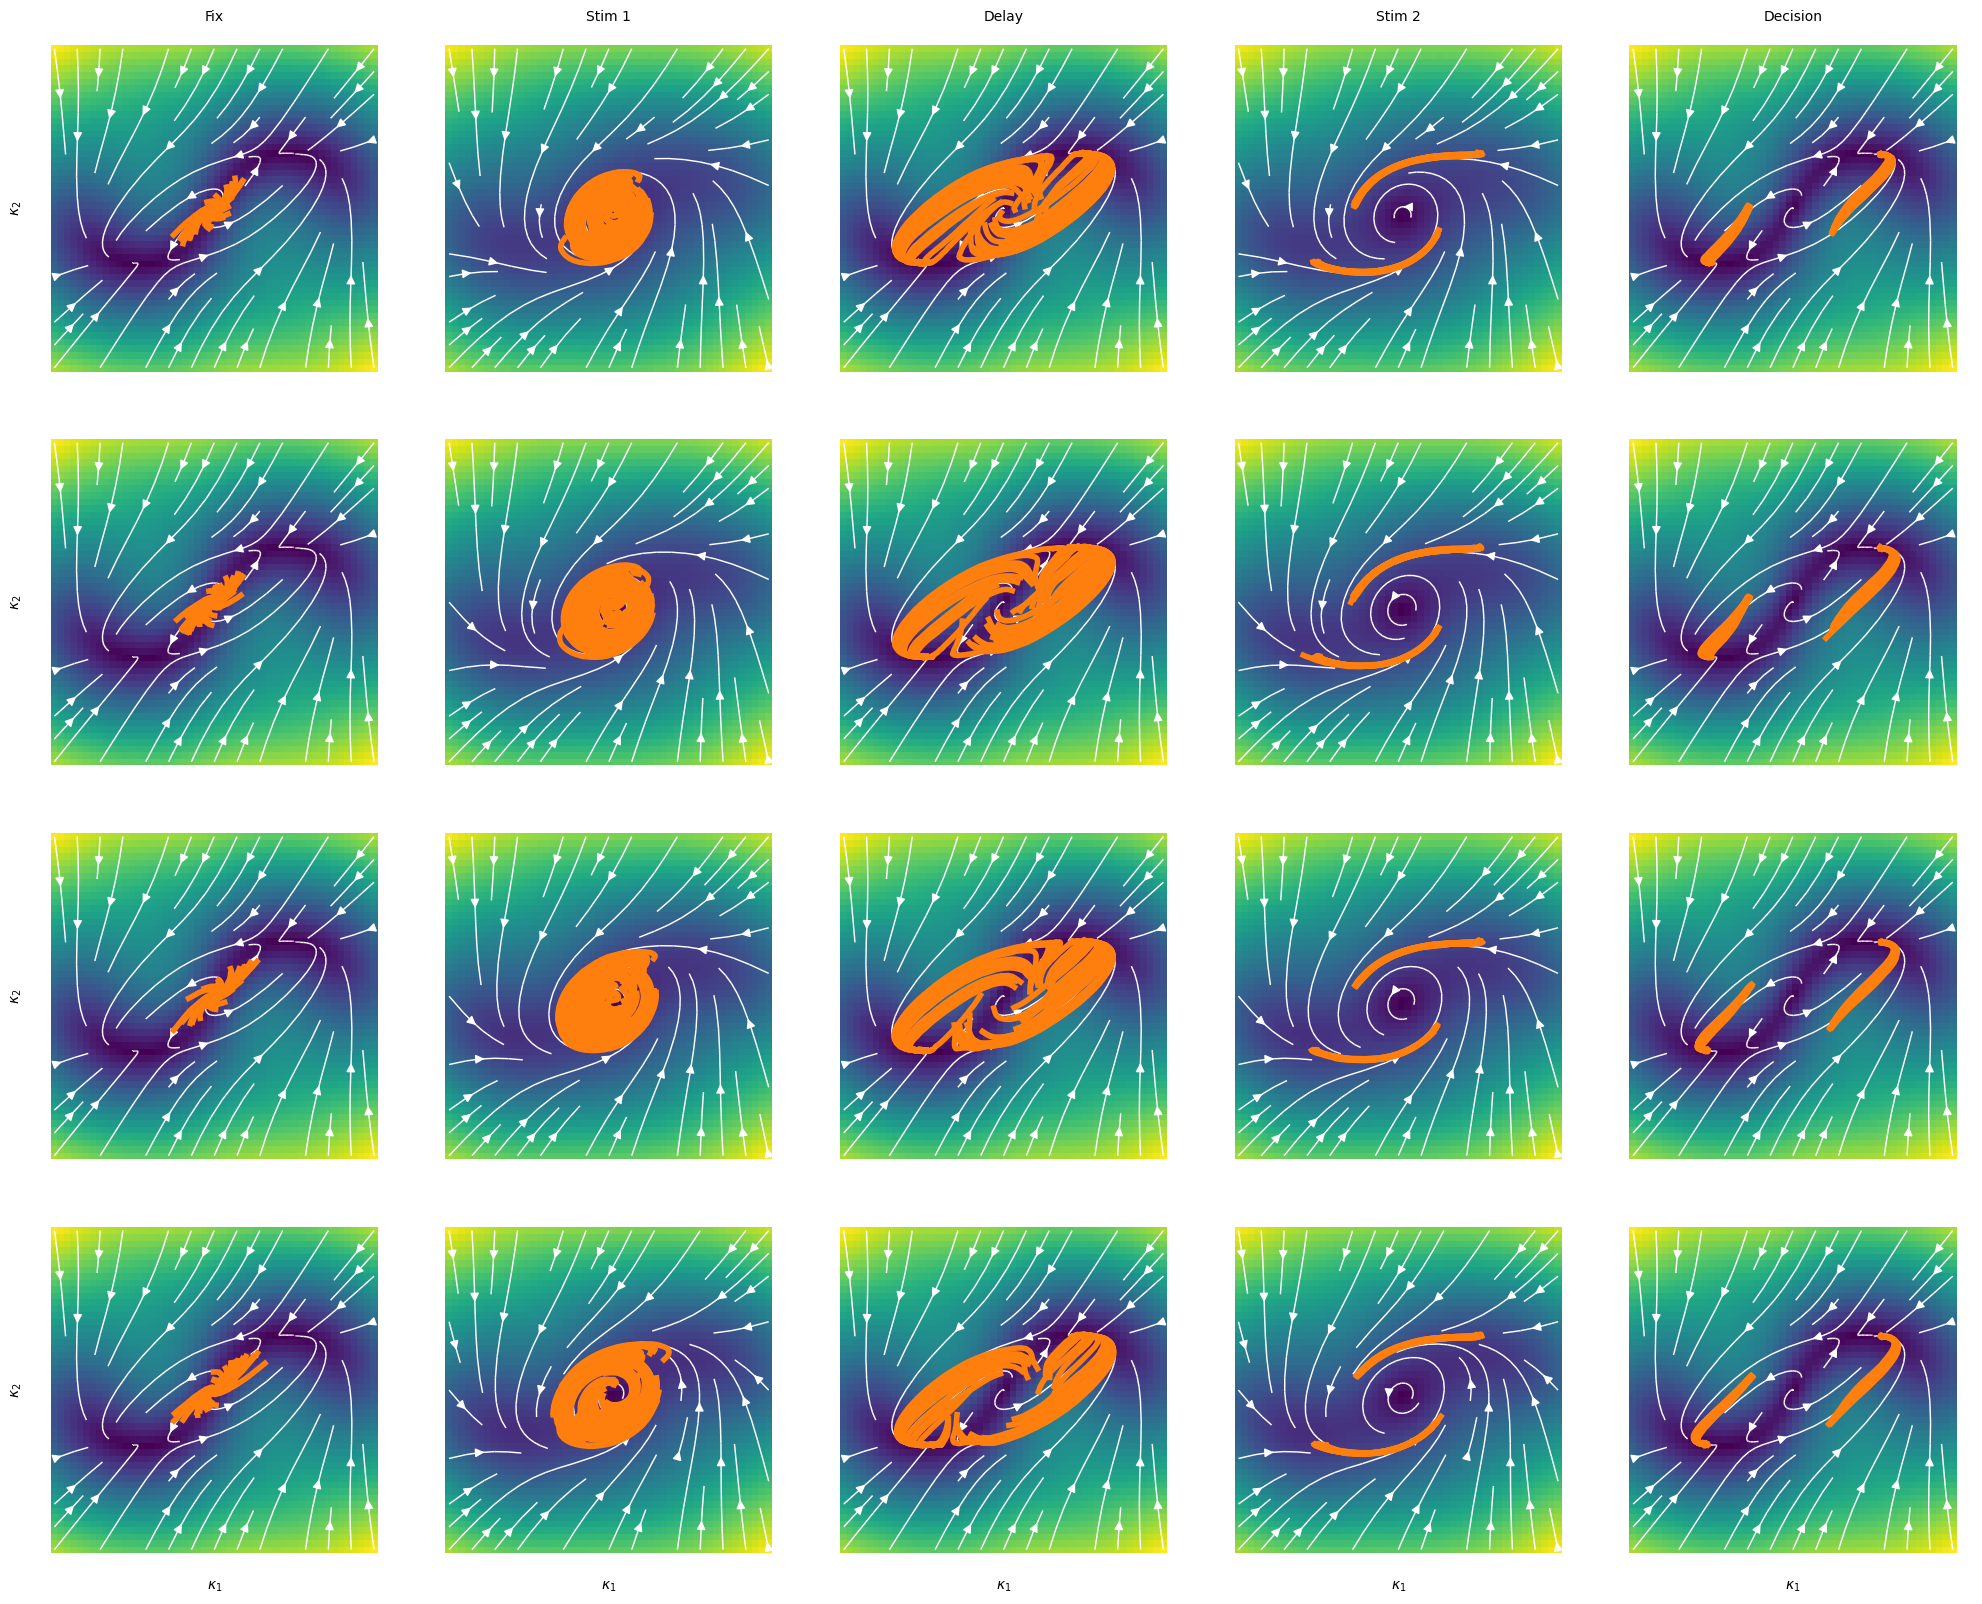

In [12]:
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i in range(4):
    for j, e in enumerate(epochs[:-1]):
        dms.plot_field(net, input[i, e], ax[i][j], sizes=1.3)
        epoch = [c[j] for c in traj[i]]
        dms.plot_trajectories(net, epoch, ax[i][j], c='C1', n_traj=len(epoch))
        #if j>0:
        #    epoch = [c[j-1] for c in conds]
        #    dms.plot_trajectories(net, epoch, ax[i][j], c='C0', n_traj=len(epoch))

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)
# plt.savefig('figures/si_dms_epochs.pdf')

# Plot phase portraits of the resampled system for various parameters

In [ ]:
n_traj=2

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
traj = []
for i in range(n_conds):
    
    conds = []
    for k in range(n_traj):
        #net.h0.data = torch.rand(size=net.h0.data.shape) #random ic
        _, traj_ = net3(input[i].unsqueeze(0))
        traj_ = traj_.squeeze().detach().numpy()
        traj_epoch = [traj_[e:epochs[j+1]] for j, e in enumerate(epochs[:-1])]
        conds.append(traj_epoch)
        
    traj.append(conds)
    
    for j, e in enumerate(epochs[:-1]):
        dms.plot_field(net3, input[i, e], ax[i][j], sizes=1.3)
        epoch = [c[j] for c in conds]
        dms.plot_trajectories(net3, epoch, ax[i][j], c='C1', n_traj=len(epoch))
        if j>0:
            epoch = [c[j-1] for c in conds]
            dms.plot_trajectories(net3, epoch, ax[i][j], c='C0', n_traj=len(epoch))

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)

In [ ]:
pickle.dump(traj, open('./outputs/RNN_data.pkl','wb'))

# Concatenate data and create dataset

In [13]:
n_neighb = 15
pca_dim = 2

n_conds = len(gain)
n_epochs = len(epochs)-1

#fit PCA to all data
pos, vel = [], []
for i in range(n_conds): #conditions
    for k in range(n_epochs): 
        for j in range(n_traj): #trajectories
            pos.append(traj[i][j][k])
            
manifold = PCA(n_components=pca_dim).fit(np.vstack(pos))

m1 = net.m[:,0].detach().numpy()
m2 = net.m[:,1].detach().numpy()
    
#aggregate data under baseline condition (no input)
pos, vel = [], []
#for i in range(n_conds): #conditions  
#    pos_, vel_ = [], []
#    for k in [0, 2, 4]:
#        for j in range(n_traj): #trajectories
#            pos_proj1 = traj[i][j][k]@m1
#            pos_proj2 = traj[i][j][k]@m2
#            pos_proj = np.stack([pos_proj1, pos_proj2], axis=1)
#            #pos_proj = manifold.transform(traj[i][j][k])
#            pos_.append(pos_proj[:-1]) #stack trajectories
#            vel_.append(np.diff(pos_proj, axis=0)) #compute differences
                        
#    pos_, vel_ = np.vstack(pos_), np.vstack(vel_) #stack trajectories
#    pos.append(pos_)
#    vel.append(vel_)
        
#aggregate data under stimulated condition
for i in range(n_conds): #conditions 
    pos_, vel_ = [], []
    for k in [1]:#[1, 3]:        
        for j in range(n_traj): #trajectories
            pos_proj1 = traj[i][j][k]@m1
            pos_proj2 = traj[i][j][k]@m2
            pos_proj = np.stack([pos_proj1, pos_proj2], axis=1)
            #pos_proj = manifold.transform(traj[i][j][k])
            pos_.append(pos_proj[:-1])
            vel_.append(np.diff(pos_proj, axis=0))
                
    pos_, vel_ = np.vstack(pos_), np.vstack(vel_) #stack trajectories
    pos.append(pos_)
    vel.append(vel_)

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=n_neighb, stop_crit=0.02, number_of_resamples=2)

---- Embedding dimension: 2
---- Signal dimension: 2

Embedding dimension <= 2, so manifold computations are disabled!


KeyboardInterrupt: 

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]

plotting.fields(data, col=4, alpha=0.2, width=0.01, scale=200, titles=titles)
plt.show()

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'epochs': 100, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data)

In [ ]:
data = model.evaluate(data)
n_clusters=20
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
labels = [g for g in gain]# for i in range(2)]
plotting.embedding(emb_MDS, labels, s=30, alpha=1)

In [ ]:
plt.imshow(data.dist)

In [ ]:
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)